In [1]:
import sys, os
sys.path.append("lib") # adding "lib" path with own packages
from Sigma_mol import sigma_mol # reads the radio sounsing and compute extinction coefficient
from scipy.interpolate import interp1d # to interpolate modeled variables to lidar heights
from lidar_integrating_space_time import Lidar_space_time as lidar_integ #integrates lidar raw data in height and time
from lidar_integrating_space_time_std import Lidar_space_time2 as lidar_integ_std #maybe not used
from fft_denoising import fft_denoising #maybe not used
from klett import Klett81b #maybe not used
import numpy as np 
import pylab #plots
from DP_simp import DP_simp # Curve simplification
from running_mean import running_mean # runing mean
from time2epoch import time2epoch #maybe not used?
#from cloud_mask_v1 import cloud_mask
from netCDF4 import Dataset 
#from time import sleep
from scipy import stats
from scipy.optimize import curve_fit
from dplots import densplot # make 2D desity plots
from Comb_LidarMRR import Comb_LidarMRR3 as Comb_LidarMRR 
from cloud_mask_v2 import cloud_mask2
from sm_paramTOP import sm_paramTOP
import matplotlib
from copy import copy
from BG_corr import BG_corr
import time

In [31]:
np.min(r_sm),r[9]

(0.11, 0.11068899881814716)

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: divide by zero encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:64: RuntimeWarning: divide by zero encountered in divide


0.210771465024 0.260020445485 0.227118545764 0.219929815664 0.215608652 0.0727952808105 0.0387231163851 0.0489282743979
0.210340102526 0.258740145347 0.225980334784 0.219746983697 0.215422143668 0.252103354134 0.117320218211 0.177335492848
[66083.638062189348, 84118.370735792982, 53440.917414752876, 34275.756655215824, 35155.799176579865, 963.83896347097402, 682.87336476006362, 626.27994187281217]


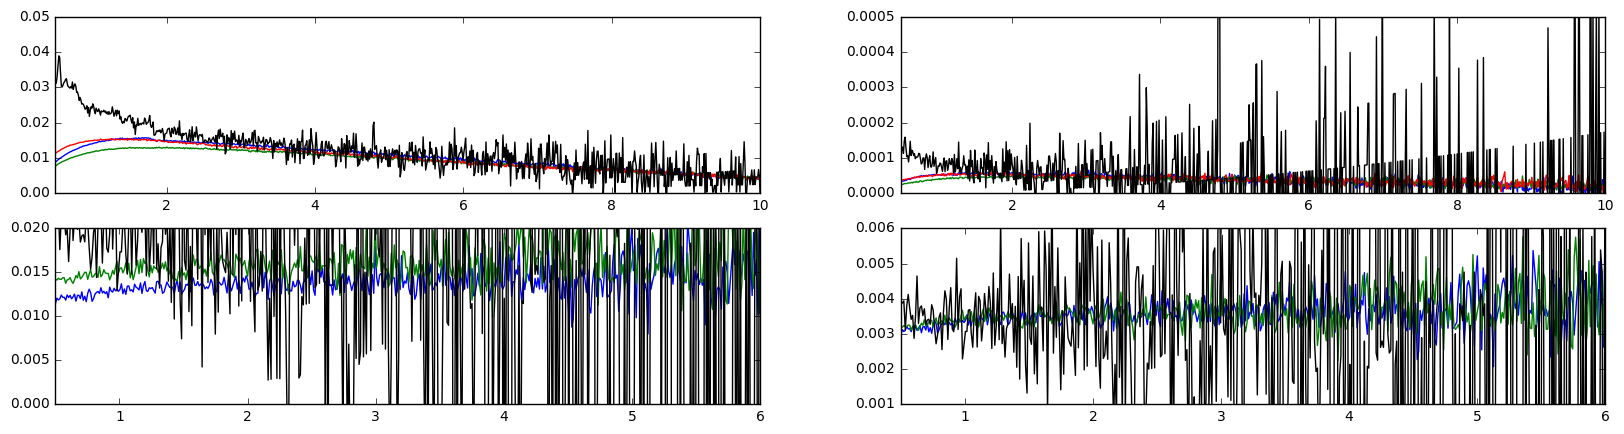

In [712]:
TRES = 5
VRES = 3

year = 2017
month = 3
day = 5
hour = 15


def CalSys(year, month, day, hour, TRES=TRES, VRES=VRES, rlim=8, doshow=True):

    path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
    filename1 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
    filename2 = path_in+"Par10_bc/Par10bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
    filename3 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

    filenameSNR = path_in+"SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
    
    r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
    Mat_Spar = np.loadtxt(filename1)
    Mat_Spar10 = np.loadtxt(filename2)
    Mat_Sper = np.loadtxt(filename3)
    SNR_Spar = np.loadtxt(filenameSNR)

    pix_r = np.squeeze(np.where(r >= rlim))[0]
    
    #SNR_par2 = np.ma.masked_where(~(SNR_par>30),SNR_par)
    #pix_r2 = np.squeeze(np.where(r >= 0.3))[0]
    
    Spar = Mat_Spar[int((60./TRES)*hour),:]
    Spar10 = Mat_Spar10[int((60./TRES)*hour),:]
    Sper = Mat_Sper[int((60./TRES)*hour),:]
    
    SNR_Spar2 = SNR_Spar[int((60./TRES)*hour),:]
    
    #pixK = np.where(~(SNR_Spar2>30))
    
    r_sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[2]
    sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[3]

    f_sm = interp1d(r_sm, sm)

    sm_lidar = f_sm(r[int(10*3./VRES):])/100000
    bm = f_sm(r[int(10*3./VRES):])/((8*np.pi/3)*1.0401)
    bm_par = 0.996*bm
    bm_per =0.00366*bm_par
    T2 = np.exp((-2*np.cumsum(sm_lidar)*(r[1]-r[0])))  

    Cpar_ = Spar[int(10*3./VRES):]/(bm_par*T2)
    Cper_ = Sper[int(10*3./VRES):]/(bm_per*T2)

    Cpar = np.nanmean(Cpar_[pix_r:])
    Cper = np.nanmean(Cper_[pix_r:])
    Cpar_std = np.nanstd(Cpar_[pix_r:])
    Cper_std = np.nanstd(Cper_[pix_r:])

    
    
    K = np.nanmedian((0.00366/(Sper/Spar)))#[pixK])
    #pylab.plot(r[pixK],(0.00366/(Sper/Spar))[pixK])
    #pylab.show()

    pix = np.where((r>0.3) & (SNR_Spar2>30))
    CC = (0.00366/(Sper/Spar))[pix]  
    
    K2 = np.nanmedian(CC)
    
    if doshow == True:
        
        pylab.plot(r[int(10*3./VRES):],1/(bm_par*T2))
        pylab.plot(r[int(10*3./VRES):],1/(bm_per*T2))
        #pylab.axis([3,10,1,0.01])
        pylab.show()
        
        pylab.plot(r[:],Spar)
        pylab.plot(r[:],Sper)
        pylab.axis([3,10,1,1000])
        pylab.xlabel("Range [km]")
        pylab.ylabel("r2-corrected Signal")
        pylab.show()

        pylab.plot(r[:],0.00366/(((Sper))/(Spar)))
        pylab.axis([3,10,0,1])
        pylab.xlabel("Range [km]")
        pylab.ylabel("Dep.Ratio")
        pylab.show()

        pylab.plot(r[int(10*3./VRES):][pix_r:],Cpar_[pix_r:])
        pylab.xlabel("Range [km]")
        pylab.ylabel("Cpar")
        pylab.show()

        pylab.plot(r[int(10*3./VRES):][pix_r:],Cper_[pix_r:])
        pylab.xlabel("Range [km]")
        pylab.ylabel("Cper")
        pylab.show()    
    
        print "Cpar = ", Cpar,'/std = ',Cpar_std,"Cper = ",Cper,'/std = ',Cper_std,"Cpar/Cper = ", Cpar/Cper
    return [[Cpar,Cper], [Spar,Spar10, Sper], r, K, SNR_Spar2, K2, [r[int(10*3./VRES):],sm_lidar]]

#2017/02/25 14UTC
#2017/03/08 14UTC
#2017/03/13 14UTC
#2017/03/15 14UTC
#2017/03/18 14UTC
#2017/04/01 10UTC
#2017/04/05 10UTC
#2017/04/18 14UTC
#2017/06/01 14UTC



C1,P1,r,K1, SNR1, CC1, sigma1 = CalSys(year, 2, 25,14, TRES = 5, VRES = 3, doshow = False)
C2,P2,r,K2, SNR2, CC2, sigma2 = CalSys(year, 3, 8, 14, TRES = 5, VRES = 3, doshow = False)
C3,P3,r,K3, SNR3, CC3, sigma3 = CalSys(year, 3, 18, 13, TRES = 5, VRES = 3, doshow = False)
C4,P4,r,K4, SNR4, CC4, sigma4 = CalSys(year, 3, 20, 16, TRES = 5, VRES = 3, doshow = False)
C5,P5,r,K5, SNR5, CC5, sigma5 = CalSys(year, 3, 21, 14, TRES = 5, VRES = 3, doshow = False)
C6,P6,r,K6, SNR6, CC6, sigma6 = CalSys(year, 8, 9, 10, TRES = 5, VRES = 3, doshow = False)
C7,P7,r,K7, SNR7, CC7, sigma7 = CalSys(year, 8, 14, 14, TRES = 5, VRES = 3, doshow = False)
C8,P8,r,K8, SNR8, CC8, sigma8 = CalSys(year, 8, 18, 10, TRES = 5, VRES = 3, doshow = False)

year = 2017
month = 8
day = 18
hour = 10
#C,P,r,K = CalSys(year, 5, 23, 12, TRES = 5, VRES = 3, doshow = False)
#C,P,r,K = CalSys(year, 5, 26, 12, TRES = 5, VRES = 3, doshow = False)
#C,P,r,K = CalSys(year, 6, 11,15, TRES = 5, VRES = 3, doshow = False) Very low Par
C,P,r,K, SNR, CC, sigma = CalSys(year, month, day,hour, TRES = 5, VRES = 3, doshow = False)

print K1,K2,K3,K4,K5,K6,K7,K8
print CC1,CC2,CC3,CC4,CC5,CC6,CC7,CC8
Cs = [C1[0],C2[0],C3[0],C4[0],C5[0],C6[0],C7[0],C8[0]]
print Cs

fig = pylab.figure(figsize=(20,5))

ax = fig.add_subplot(2,2, 1)
pylab.plot(r,P1[0]/C1[0])
pylab.plot(r,P2[0]/C2[0])
pylab.plot(r,P3[0]/C3[0])
#pylab.plot(r,P4[0])
#pylab.plot(r,P5[0])
pylab.plot(r,P[0]/C[0], color = "black")
pylab.axis([0.5,10,0,0.05])

ax = fig.add_subplot(2,2, 2)
pylab.plot(r,CC1*P1[2]/C1[0])
pylab.plot(r,CC2*P2[2]/C2[0])
pylab.plot(r,CC3*P3[2]/C3[0])
#pylab.plot(r,P4[0])
#pylab.plot(r,P5[0])
pylab.plot(r,CC*P[2]/C[0], color = "black")
pylab.axis([0.5,10,0,0.0005])

ax = fig.add_subplot(2,2, 3)
#pylab.plot(r,P1[1]/P1[0])
pylab.plot(r,P2[2]/P2[0])
pylab.plot(r,P3[2]/P3[0])
#pylab.plot(r,P4[1]/P4[0])
#pylab.plot(r,P5[1]/P5[0])
pylab.plot(r,P[2]/P[0], color = "black")
pylab.axis([0.5,6,0.00,0.02])

ax = fig.add_subplot(2,2, 4)
#pylab.plot(r,K1*P1[1]/P1[0])
pylab.plot(r,CC2*P2[2]/P2[0])
pylab.plot(r,CC3*P3[2]/P3[0])
#pylab.plot(r,K4*P4[1]/P4[0])
#pylab.plot(r,K5*P5[1]/P5[0])
pylab.plot(r,CC*P[2]/P[0], color = "black")
pylab.axis([0.5,6,0.001,0.006])
pylab.show()

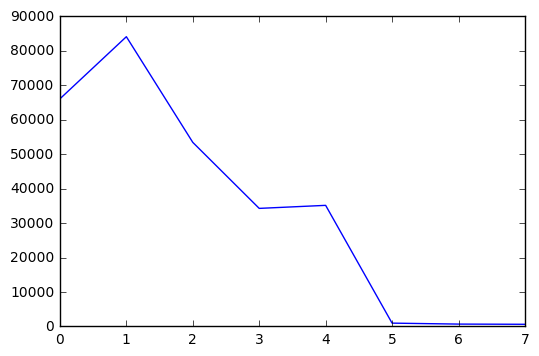

[66083.638062189348, 84118.370735792982, 53440.917414752876, 34275.756655215824, 35155.799176579865, 963.83896347097402, 682.87336476006362, 626.27994187281217]


In [709]:
pylab.plot(Cs)
pylab.show()

pylab.plot([0.210340102526 0.258740145347 0.225980334784 0.219746983697 0.215422143668 0.252103354134 0.117320218211 0.177335492848])

print Cs

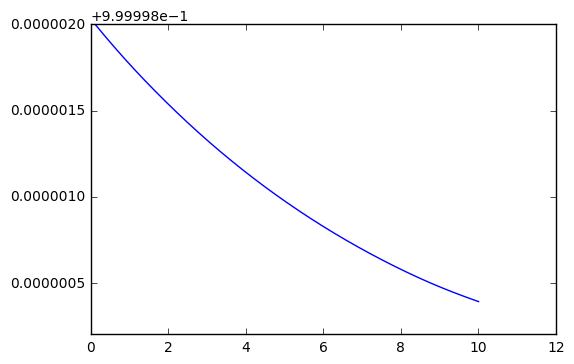

In [618]:
pylab.plot(sigma2[0],np.exp(-2*np.cumsum(sigma2[1]/1000.)*(sigma2[0][1]-sigma2[0][0])/1000.))
pylab.show()

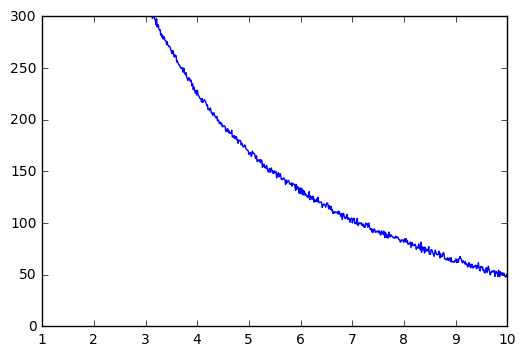

In [654]:
pylab.plot(r,SNR2)
pylab.axis([1,10,0,300])
pylab.show()

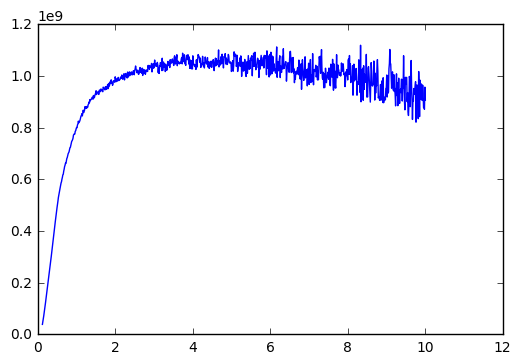

[  3.90098566e+07   4.92539684e+07   6.01761225e+07   7.19529702e+07
   8.41000964e+07   9.67000119e+07   1.09711185e+08   1.23221487e+08
   1.36862890e+08   1.50674334e+08   1.64510985e+08   1.77649636e+08
   1.91472601e+08   2.04576390e+08   2.18508004e+08   2.31870625e+08
   2.46534734e+08   2.60137686e+08   2.74666036e+08   2.88994282e+08
   3.02921676e+08   3.18086352e+08   3.34261463e+08   3.47859692e+08
   3.62632877e+08   3.77336323e+08   3.93634623e+08   4.07888343e+08
   4.22446093e+08   4.36342731e+08   4.50729342e+08   4.62305060e+08
   4.78707365e+08   4.91543742e+08   5.02966367e+08   5.16166971e+08
   5.30141734e+08   5.40162568e+08   5.51919779e+08   5.59012866e+08
   5.67868711e+08   5.76458045e+08   5.86058247e+08   5.91103906e+08
   6.00962960e+08   6.08048097e+08   6.17655671e+08   6.20134038e+08
   6.31976146e+08   6.39846446e+08   6.49854695e+08   6.55169476e+08
   6.63002116e+08   6.62051537e+08   6.70839816e+08   6.81038905e+08
   6.84851574e+08   6.91620437e+08

In [655]:
pylab.plot(sigma2[0],P2[0][int(10*3./VRES):]/((sigma2[1]/100000.)*np.exp(-2*np.cumsum(sigma2[1]/100000.)*(sigma2[0][1]-sigma2[0][0]))))
#pylab.plot(sigma2[0],(1./42222)*P2[0][int(10*3./VRES):])
#pylab.plot(sigma2[0],sigma2[1]/100000.)
pylab.show()

print P2[0][int(10*3./VRES):]/((sigma2[1]/100000.)*np.exp(-2*np.cumsum(sigma2[1]/100000.)*(sigma2[0][1]-sigma2[0][0])))

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in divide


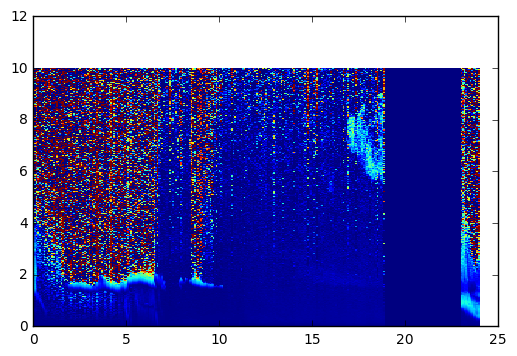

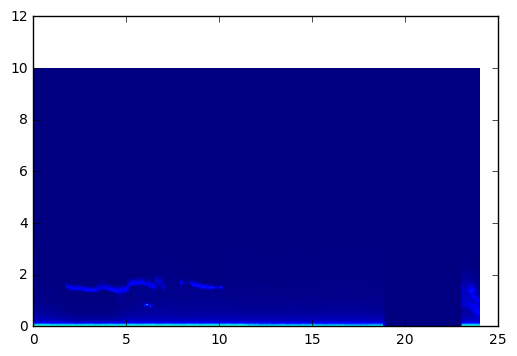

In [451]:
path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
filename1 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
filename3 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
filenameSNR = path_in+"SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
Mat_Spar = np.loadtxt(filename1)
Mat_Sper = np.loadtxt(filename3)
SNR_par = np.loadtxt(filenameSNR)
hours = np.linspace(0,24,np.shape(Mat_Spar)[0])

pylab.pcolor(hours,r,K*np.transpose(Mat_Sper/Mat_Spar), vmin = 0, vmax = 0.1)
pylab.show()
pylab.pcolor(hours,r,np.transpose(SNR_par),vmin = 0, vmax = 10000)
pylab.show()

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


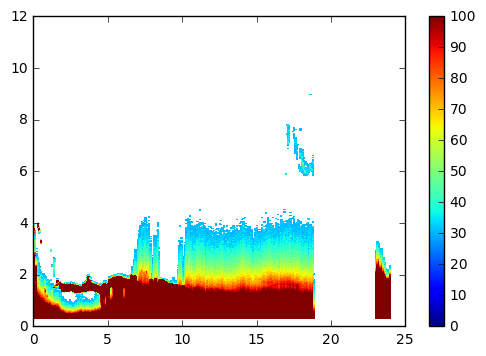

In [485]:
SNR_par2 = np.ma.masked_where(~((SNR_par>30) & (r>0.3)),SNR_par)
#SNR_par2 = np.ma.masked_where(~(((SNR_par2) < 0) & ((SNR_par2) >= 0)),SNR_par2)

pylab.pcolor(hours,r,np.transpose(SNR_par2),vmin = 0, vmax = 100)
pylab.colorbar()
pylab.show()



[295479.38326833793, 1283266.9893993114]
[387222.20356238307, 1856049.0951779026]
[244875.14589933, 1475818.3965653554]
0.230255578698 0.208627134147 0.165924985397


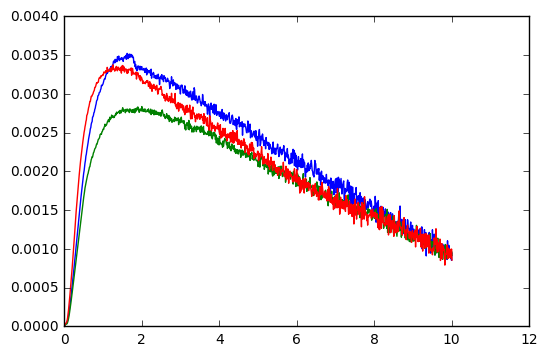

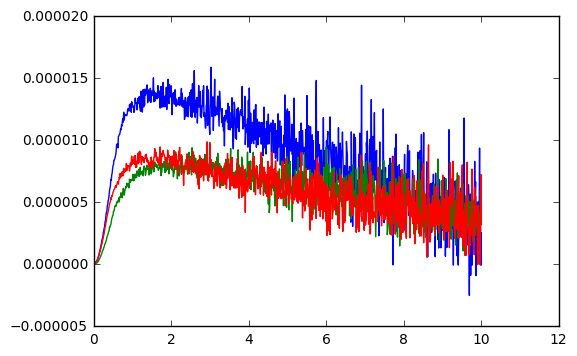

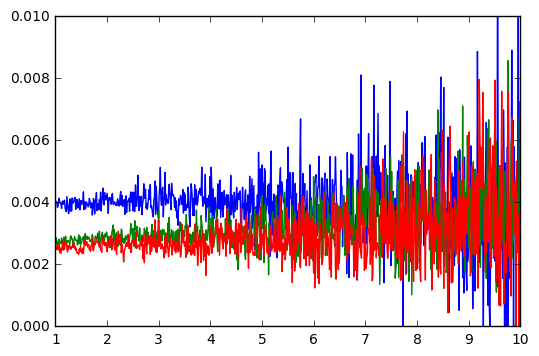

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: divide by zero encountered in divide


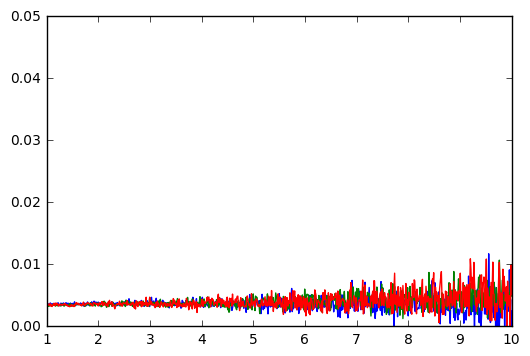

In [243]:
print Cal1[0]
print Cal2[0]
print Cal3[0]
print Cal1[0][0]/Cal1[0][1],Cal2[0][0]/Cal2[0][1],Cal3[0][0]/Cal3[0][1]

pylab.plot(Cal1[2][2],Cal1[2][0]/Cal1[0][0])
pylab.plot(Cal2[2][2],Cal2[2][0]/Cal2[0][0])
pylab.plot(Cal3[2][2],Cal3[2][0]/Cal3[0][0])
pylab.show()

pylab.plot(Cal1[2][2],Cal1[2][1]/Cal1[0][1])
pylab.plot(Cal2[2][2],Cal2[2][1]/Cal2[0][1])
pylab.plot(Cal3[2][2],Cal3[2][1]/Cal3[0][1])
pylab.show()

pylab.plot(Cal1[2][2],(Cal1[2][1]/Cal1[2][0])*(Cal1[0][0]/Cal1[0][1]))
pylab.plot(Cal2[2][2],(Cal2[2][1]/Cal2[2][0])*(Cal2[0][0]/Cal2[0][1]))
pylab.plot(Cal3[2][2],(Cal3[2][1]/Cal3[2][0])*(Cal3[0][0]/Cal3[0][1]))
pylab.axis([1,10,0,0.01])
pylab.show()

K1 = np.nanmedian((0.00366/(Cal1[2][1]/Cal1[2][0])))
K2 = np.nanmedian((0.00366/(Cal2[2][1]/Cal2[2][0])))
K3 = np.nanmedian((0.00366/(Cal3[2][1]/Cal3[2][0])))


pylab.plot(Cal1[2][2],K1*(Cal1[2][1]/Cal1[2][0]))
pylab.plot(Cal2[2][2],K2*(Cal2[2][1]/Cal2[2][0]))
pylab.plot(Cal3[2][2],K3*(Cal3[2][1]/Cal3[2][0]))
pylab.axis([1,10,0,0.05])
pylab.show()

In [66]:
Cpar =  331077.319291 /std =  21207.0732497 Cper =  2428318.65784 /std =  816402.273351 Cpar/Cper =  0.136340145566
Cpar =  337426.257255 /std =  9169.08627914 Cper =  2197662.30654 /std =  373970.868415 Cpar/Cper =  0.153538719871

1.0010188987384854